[Ссылка](https://www.kaggle.com/competitions/airbus-ship-detection/overview) на соревнование

# Imports / Configuration

In [1]:
%rm -rf sample_data
%mkdir ./airbus_ship_detection
%cd ./airbus_ship_detection
%mkdir ./inputs
%ls

/content/airbus_ship_detection
inputs/


In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from google.colab import drive
from functools import partial
from sklearn.cluster import KMeans
from typing import Union, List, Tuple, Dict

## Mount google drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Download the competition data from Kaggle

In [4]:
# updating the Kagggle API module using pip
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install "kaggle>=1.5.6"

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=e3eade68e57839330020ca5c5a193eccf9c6d481a728f346b38c0addea789c27
  Stored in directory: /root/.cache/pip/wheels/03/f3/c7/fc5a63bb33d22177609b06c5b4c714b5eb3f1b195ce9dc5e47
Successfully built kaggle


In [5]:
# добавляем в переменные окружения папку, в которой находится kaggle.json с токеном для kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = '//content/drive/MyDrive/kaggle'

In [6]:
# download the competition data
!kaggle competitions download -c airbus-ship-detection --path . --force --quiet

In [7]:
# unzip the competition data
!unzip -qq airbus-ship-detection.zip -d inputs
%rm -rf airbus-ship-detection.zip

# Visualize the data

## Metadata

In [8]:
# load initial metadata
metadata = pd.read_csv("./inputs/train_ship_segmentations_v2.csv")

print(metadata.shape)
display(metadata.head())

(231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


- `ImageId` - image name
- `EncodedPixels` - no ships on the image if NaN else encoded pixels of the image with ship representation

Each row represents just one ship if ship exists at corresponding image.

In [9]:
def get_mask(width: int, height: int, rle: str) -> np.ndarray:
  """
  The function takes rle (run-length encoding) data and returns 
  corresponding segmentation mask with reference image shape, where value 0 of
  the pixel means that this pixel is part of the backgroud, value 1 - the pixel
  is a part of an corresponding object. 
  :param width: corresponding image width
  :param height: corresponding image height
  :param rle: encoded mask
  """
  pairs = np.fromiter(map(int, rle.split()), dtype="int32").reshape(-1, 2)
  mask = np.zeros(shape=(width*height, ), dtype="uint")
  for start, length in pairs:
    start -= 1  # rle starts with 1 (not 0)
    mask[start: start + length] = 1
  return mask.reshape(width, height).T


def get_bbox(width: int, height: int, rle: str) -> Tuple[Union[int, float]]:
  """
  The function takes rle (run-length encoding) data and returns 
  corresponding bounding box throught coordinates of left upper corner pixel (x0, y0) 
  and right bottom corner pixel (x1, y1). Both pixels are the parts of corresponding
  object.
  :param width: corresponding image width
  :param height: corresponding image height
  :param rle: encoded mask
  """
  # x0, y0 - left upper corner
  # x1, y1 - right lower corner
  pairs = np.fromiter(map(int, rle.split()), dtype="int32").reshape(-1, 2)

  # getting y0 coordinate
  x0, y0 = float( "inf"), float( "inf")
  x1, y1 = float("-inf"), float("-inf")
  for start, length in pairs:
    # rle starts with 1 (not 0)
    x_coordinate = start // height + (1 if start % height else 0) - 1
    y_coordinate = (start % height if start % height else height) - 1
    x0, x1 = min(x0, x_coordinate), max(x1, x_coordinate)
    y0, y1 = min(y0, y_coordinate), max(y1, y_coordinate + length - 1)
  return x0, y0, x1, y1


def extract_data(row: pd.Series, img_loc: str) -> Tuple[Union[int, float]]:
  """
  The function returns:
  - image width
  - image height
  - x0 (left upper corner x coordinate) 
  - y0 (left upper corner y coordinate) 
  - x1 (right lower corner x coordinate) 
  - y1 (right lower corner y coordinate) 
  """
  fname, enc_pixels = row.values
  with Image.open(os.path.join(img_loc, fname)) as img:
    width, height = img.size

  x0, y0, x1, y1 = get_bbox(width=width, height=height, rle=enc_pixels)
  return width, height, x0, y0, x1, y1


def plot_image(img_meta: pd.Series, img_loc: str = "./inputs/train_v2", 
               figsize: Tuple[int] = (12, 12)) -> None:
  fname, enc_pixels = img_meta[["ImageId", "EncodedPixels"]].values
  with Image.open(os.path.join(img_loc, fname)) as img:
    width, height = img.size

    # plot the image
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.imshow(img)

    # plot the mask
    mask = get_mask(width=width, height=height, rle=enc_pixels)
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(mask, alpha=0.3, cmap="jet", label="mask")

    # plot bounding box throught centers of the pixels at the edges of the object
    x0, y0, x1, y1 = img_meta[["x0", "y0", "x1", "y1"]].values
    pix_rect = \
      patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=1, edgecolor='r', 
                        facecolor='none', label="bounding box", ls="--")
    ax.add_patch(pix_rect)

    # plot the center of the bounding box
    x_center, y_center = img_meta[["x_center", "y_center"]].values
    ax.scatter(x_center, y_center, s=100, color="red", marker="x")

    # plot bounding box based calculated from the center bounding box coordinates
    # and its width and height
    bbox_width, bbox_height = img_meta[["bbox_width", "bbox_height"]].values
    x0, y0, x1, y1 = \
      x_center - (bbox_width / 2), y_center - (bbox_height / 2), \
      x_center + (bbox_width / 2), y_center + (bbox_height / 2)
    pix_rect = \
      patches.Rectangle((x0, y0), bbox_width, bbox_height, linewidth=3, edgecolor='r', 
                        facecolor='none', label="bounding box", ls="-")
    ax.add_patch(pix_rect)

    ax.grid("off")
    ax.axis("off")
    ax.set_xlim(left=x0 - 1, right=x1 + 1)
    ax.set_ylim(top=y0 - 1, bottom=y1 + 1)
    fig.show()
    return

In [10]:
# get image widht and height, coordinates of the left upper corner and right bottom corner of the bounding box
parsed_metadata = \
  metadata[~metadata["EncodedPixels"].isna()].apply(partial(extract_data, img_loc="./inputs/train_v2"), axis=1)
parsed_metadata = pd.DataFrame(data=list(zip(*parsed_metadata.values)),
                               columns=parsed_metadata.index, 
                               index=["width", "height", "x0", "y0", "x1", "y1"]).T
metadata = metadata.merge(parsed_metadata, how="left", left_index=True, right_index=True)

In [11]:
# check results
assert ((metadata["height"] > metadata["y1"]) | (metadata["EncodedPixels"].isna())).all()
assert ((metadata["width"] > metadata["x1"]) | (metadata["EncodedPixels"].isna())).all()
assert ((metadata["x0"] >= 0) | (metadata["EncodedPixels"].isna())).all()
assert ((metadata["y0"] >= 0) | (metadata["EncodedPixels"].isna())).all()
assert ((metadata["x0"] <= metadata["x1"]) | (metadata["EncodedPixels"].isna())).all()
assert ((metadata["y0"] <= metadata["y1"]) | (metadata["EncodedPixels"].isna())).all()

In [12]:
# calculate center of the bounding box and it's widht and height
metadata["x_center"] = (metadata["x0"] + metadata["x1"]) / 2
metadata["y_center"] = (metadata["y0"] + metadata["y1"]) / 2
metadata["bbox_height"] = metadata["y1"] - metadata["y0"] + 1
metadata["bbox_width"] = metadata["x1"] - metadata["x0"] + 1

print(metadata.shape)
display(metadata.head())

(231723, 12)


,ImageId,EncodedPixels,width,height,x0,y0,x1,y1,x_center,y_center,bbox_height,bbox_width
0,00003e153.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0001124c7.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768.0,768.0,344.0,465.0,447.0,500.0,395.5,482.5,36.0,104.0
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768.0,768.0,469.0,287.0,491.0,306.0,480.0,296.5,20.0,23.0
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768.0,768.0,67.0,377.0,84.0,385.0,75.5,381.0,9.0,18.0


Few examples with bounding box and mask

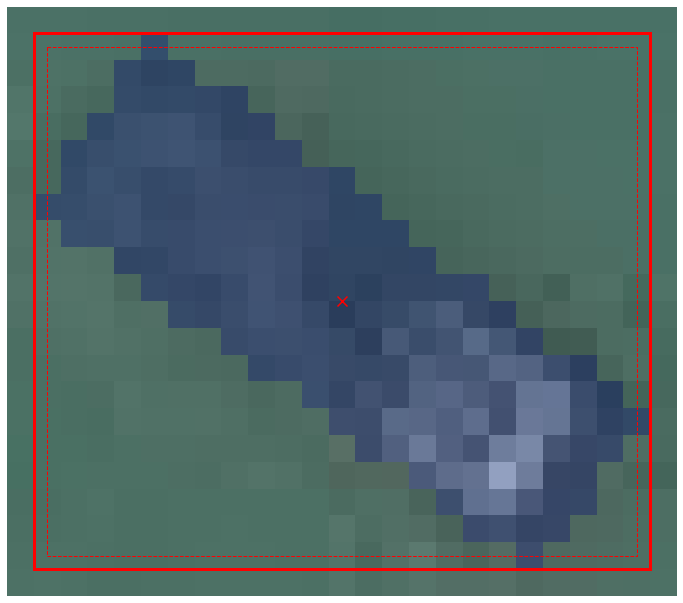

In [ ]:
plot_image(metadata.loc[3])

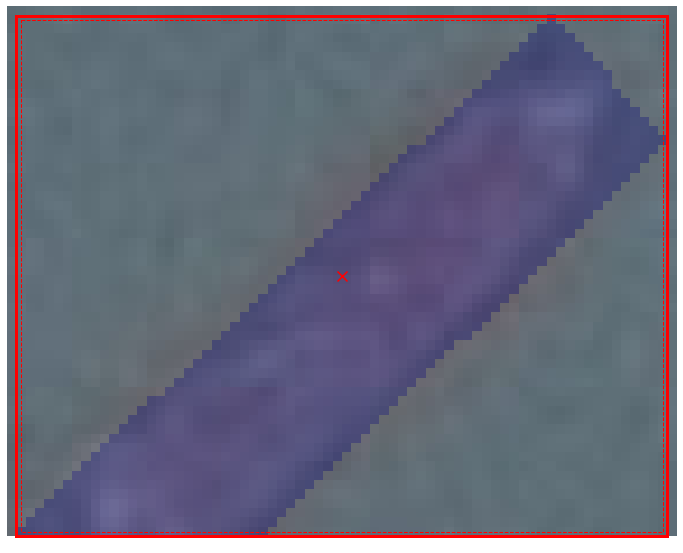

In [ ]:
plot_image(metadata.loc[106])

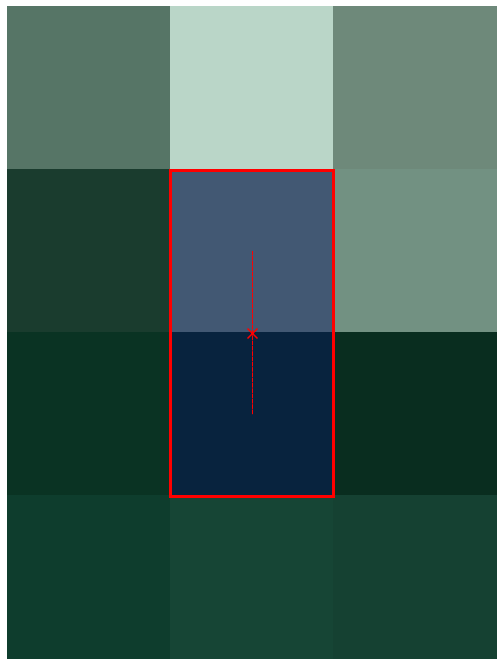

In [ ]:
plot_image(metadata.loc[2272])

Seems that bounding box drawn correctly.

## Bounding boxes shape and masks distribution

Seems, that bounding boxes are specified correctly. Let's have a look, how our data is distributed.

**How many images without ships on it?**

In [ ]:
n_ships_data = metadata.groupby(by="ImageId")["EncodedPixels"].count()

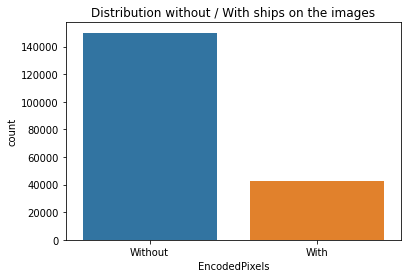

In [ ]:
ax = sns.countplot(x=(n_ships_data != 0))
ax.set(
    title="Distribution without / With ships on the images",
    xticklabels=["Without", "With"]
);

In [ ]:
(n_ships_data != 0).value_counts().rename(index={False: "Without", True: "With"})

Without    150000
With        42556
Name: EncodedPixels, dtype: int64

**Ships quantity distribution per image if exists**

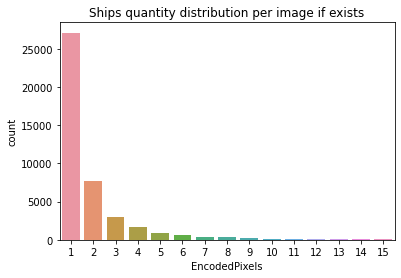

In [ ]:
ax = sns.countplot(x=n_ships_data[n_ships_data != 0])
ax.set(
    title="Ships quantity distribution per image if exists",
);

In [ ]:
n_ships_data[n_ships_data != 0].value_counts()

1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: EncodedPixels, dtype: int64

**Image size distribution**

In [ ]:
metadata["height"].unique()

array([ nan, 768.])

In [ ]:
metadata["width"].unique()

array([ nan, 768.])

As you can see, all the images has same image size - [768 x 768]

**How relative bounding box sizes are distributed?**

In [40]:
metadata_with_object = metadata.dropna(axis=0, subset=["EncodedPixels"])

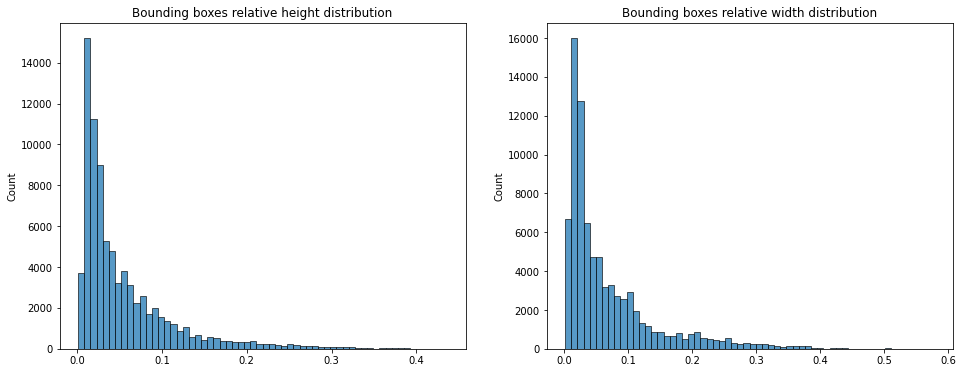

In [ ]:
fig, (h_distr, w_distr) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(x=metadata_with_object["bbox_height"] / metadata_with_object["height"], bins=60, ax=h_distr)
sns.histplot(x=metadata_with_object["bbox_width"] / metadata_with_object["width"], bins=60, ax=w_distr)
h_distr.set(
    title="Bounding boxes relative height distribution"
)
w_distr.set(
    title="Bounding boxes relative width distribution"
);

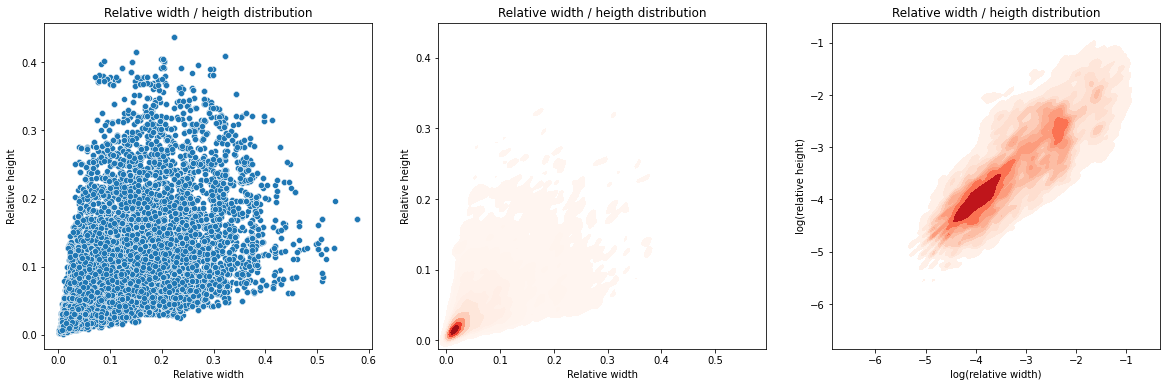

In [ ]:
fig, (ax_scatter, ax_heat, ax_log) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(
    x=metadata_with_object["bbox_width"] / metadata_with_object["width"],
    y=metadata_with_object["bbox_height"] / metadata_with_object["height"], ax=ax_scatter)
sns.kdeplot(
    x=metadata_with_object["bbox_width"] / metadata_with_object["width"],
    y=metadata_with_object["bbox_height"] / metadata_with_object["height"], 
    cmap="Reds", shade=True, bw_adjust=.5, ax=ax_heat)
sns.kdeplot(
    x=np.log(metadata_with_object["bbox_width"] / metadata_with_object["width"]),
    y=np.log(metadata_with_object["bbox_height"] / metadata_with_object["height"]), 
    cmap="Reds", shade=True, bw_adjust=.5, ax=ax_log)

ax_scatter.set(
    xlabel="Relative width",
    ylabel="Relative height",
    title="Relative width / heigth distribution"
)
ax_heat.set(
    xlabel="Relative width",
    ylabel="Relative height",
    title="Relative width / heigth distribution"
)
ax_log.set(
    xlabel="log(relative width)",
    ylabel="log(relative height)",
    title="Relative width / heigth distribution"
);

**How masks are distributed on the images?**

In [ ]:
masks = np.zeros(shape=(768, 768))
for _, row in metadata[["width", "height", "EncodedPixels"]].iterrows():
  if isinstance(row.get("EncodedPixels"), str):
    width, height, rle = row.values
    width, height = int(width), int(height)
    mask = get_mask(width, height, rle)
    masks += mask
masks = (masks - masks.min()) / (masks.max() - masks.min())

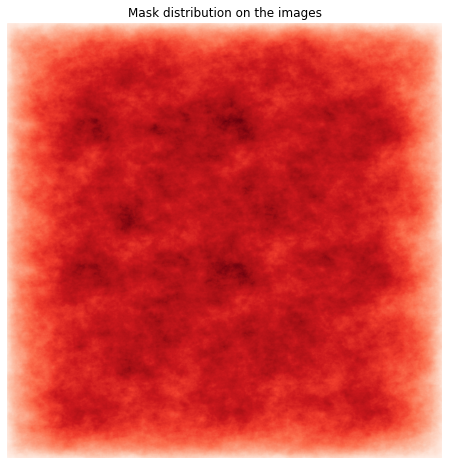

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(masks, cmap="Reds")
ax.grid("off")
ax.axis("off")
ax.set_title(label="Mask distribution on the images");

# Clustering to get an initial guess for anchors

## Theory

[Article](https://towardsdatascience.com/training-yolo-select-anchor-boxes-like-this-3226cb8d7f0b) with good explanation of anchors tuning.

Selection of good anchors is important because YOLO predicts bounding boxes not directly, but as displacements from anchor boxes. Naturally, neural networks predict small displacements better (more accurately) than large displacements. So the better you choose the anchor boxes, the less “work” will be done by a neural network, and the higher the accuracy the model will produce.

Auto-anchor algorithm was introduced in the YOLOv5 repository and later copy-pasted to the YOLOv7 repository without any changes. The idea of the algorithm is the following:

Before training, the script checks how well provided anchors fit the data, and if they do not fit well, the script recalculates them; and the model is trained with new, more appropriate anchors. Sounds like an extremely useful feature, isn’t it?

**Metric to define arnchor box fitness**

How fitness metric is calculated in YOLOv5 and YOLOv7. There are 3 anchors in this example, in YOLOs by default — 9 anchors. Calculation should be made on already resized images and resized bounding boxed accordingly.

<img src="https://miro.medium.com/max/1400/1*CsaDQUA9WDLAOPpcEPGJrA.webp"></img>

## Getting initial guess using KNN clustering

In [78]:
# 9 clusters for YoLo
kmeans = KMeans(n_clusters=9, random_state=42).fit(
    metadata.loc[~metadata["EncodedPixels"].isna(), ["bbox_width", "bbox_height"]].values)
metadata.loc[~metadata["EncodedPixels"].isna(), "cluster"] = kmeans.labels_

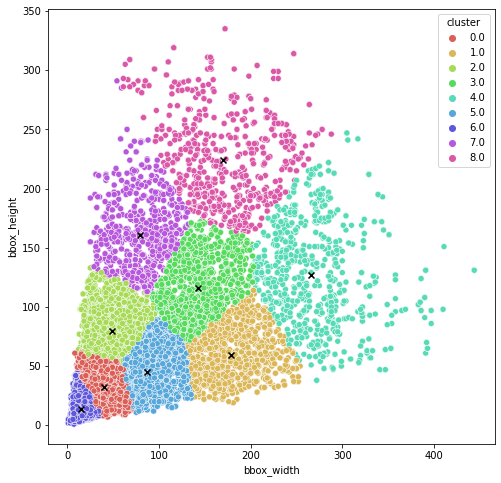

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=metadata, x="bbox_width", y="bbox_height", hue="cluster", palette=sns.color_palette("hls", 9), ax=ax)
ax.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], c="black", marker="x");

In [81]:
# relative sizes of bounding boxes
kmeans.cluster_centers_ / 768

array([[0.05208766, 0.04225233],
       [0.23266494, 0.07765489],
       [0.06340369, 0.1034118 ],
       [0.18589801, 0.15141759],
       [0.34565368, 0.16538194],
       [0.11261608, 0.05893354],
       [0.01893375, 0.01767838],
       [0.10253858, 0.20948272],
       [0.22113875, 0.29163192]])